In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
print(os.listdir("../input"))  # input内のファイル表示
import warnings
warnings.filterwarnings("ignore")  # 原因不明の実行エラーが出たら邪魔だから表示させない

# rcParamsは辞書だけど、これを書き換えれば全体の設定が変わるよ
plt.rcParams['figure.figsize'] = (16, 9)
sns.set_palette('gist_earth')  # snsで使うカラーパレット指定


['.DS_Store', 'gender_submission.csv', 'test.csv', 'train.csv']


In [248]:
# read datasets
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
# Merge 2 dataset for EDA and feature Engineering
# Explanatory Data Analysis（略してEDA）とは、データの特徴を探求し、
# 構造を理解することを目的としたデータサイエンスの最初の一歩
df_train.head(10)
df_train.head(10)
full = pd.concat([df_train, df_test], axis=0, sort=True)
full.head(10)
# set passengerId as index
full.set_index('PassengerId', drop=False, inplace=True)
train = full[:891]
# inplaceは元の配列を変更するかどうか、dropはindex列を捨てるかどうか
full.head(10)
print("Dataset containns {} records, with {} variables.".format(full.shape[0], full.shape[1]))

Dataset containns 1309 records, with 12 variables.


In [249]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [250]:
# idenfity missing values
nan = full.isnull() # dataframeの中で、
# nuneかどうかそれぞれのデータについて判定、TorFを格納
nan.head(10)
type(nan)

pandas.core.frame.DataFrame

In [251]:
# idenfity missing values
nan = full.isnull().sum()  # sum()はDataframeに対しては列ごとに合計を計算 
nan.head(10)

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
dtype: int64

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Survived'], dtype='object')


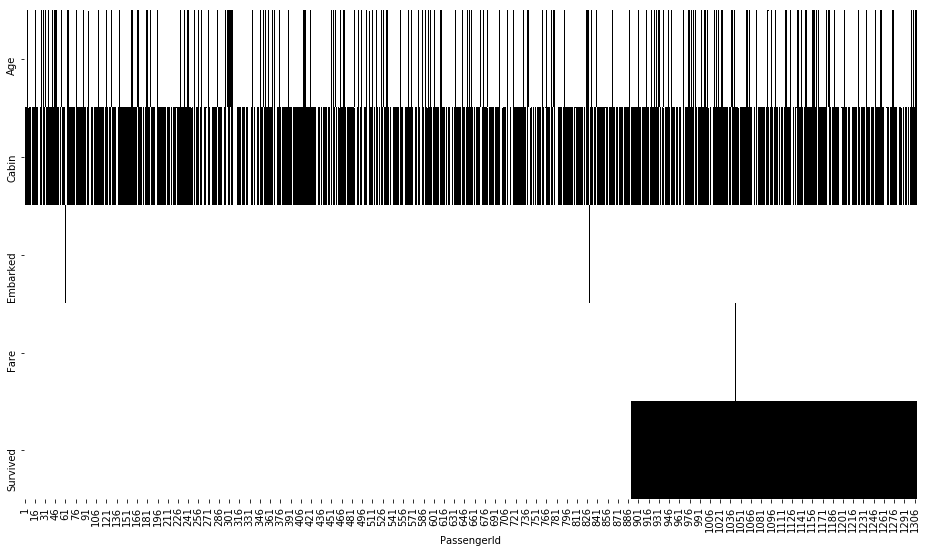

In [252]:
nan = full.isnull().sum()
idx_nan = nan.mask(nan==0).dropna().index  
print(idx_nan)
# mask()は　条件に合わないところは、オリジナルの値を維持。
# dropnaで0もしくはNaNを除く.indexでindexのみのリスト作成
# cbar:カラーバーをどこに置くか。今回なし
# cmapはカラーマップか。binaryだと2色なんだろな
sns.heatmap(full[idx_nan].transpose().isnull(), cmap='binary', cbar=False)
# 欠損値を持つデータについて、
# transpose()転置

In [253]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [254]:
nan[idx_nan].drop('Survived').sort_values() # 整列。survived落とす

Fare           1
Embarked       2
Age          263
Cabin       1014
dtype: int64

In [255]:
# data cleaning
# ticket and cabin gives us information about where passengers is
# 先ずはチケットから
np.sort(full['Ticket'].unique())  # uniqueは要素の重複をなくしたものを返す

array(['110152', '110413', '110465', '110469', '110489', '110564',
       '110813', '111163', '111240', '111320', '111361', '111369',
       '111426', '111427', '111428', '112050', '112051', '112052',
       '112053', '112058', '112059', '112277', '112377', '112378',
       '112379', '112901', '113028', '113038', '113043', '113044',
       '113050', '113051', '113054', '113055', '113056', '113059',
       '113501', '113503', '113505', '113509', '113510', '113514',
       '113572', '113760', '113767', '113773', '113776', '113778',
       '113780', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113790', '113791', '113792', '113794',
       '113795', '113796', '113798', '113800', '113801', '113803',
       '113804', '113806', '113807', '11668', '11751', '11752', '11753',
       '11755', '11765', '11767', '11769', '11770', '11771', '11774',
       '11778', '11813', '11967', '1222', '12233', '12460', '12749',
       '13049', '13050', '13213', '13214', '13236',

In [256]:
def parse_ticket(str1):
    '''
    function to parse the letter part of the ticket code
    '''
    # \dは数字\d{4,7}で4から7桁の数字
    # |はor
    m = re.search(r'(.*)(\s\d|\s\d{4,7}$)', str1)
    # print(str1, end="\t")
    # if m:
        # print("m", m.group(0))
    # .は改行以外の任意の１文字
    # \s=スペース、$は末尾にマッチ
    s = re.search(r'[A-Z]+', str1)  # TorFが格納。マッチなので。
    # print(s)
    if m:
        str2 = m.group(1)  # マッチした部分の1番目
        # print("str2", str2)
        # print("{}\t{}\t{}\t{}".format(str1, m.group(0), 
        #                          m.group(1), m.group(2)))
        # ()で中身キャプチャ、[A-Z]でA-Zの文字、+でその1個以上の連続
        # *だと0個以上の連続
        # ^先頭にマッチ
        # マッチとキャプチャは違うよ
        # 正規表現を使う時、\の改行には気をつけようね。
        n = re.search(r'([A-Z]+)[^A-Z0-9]*([A-Z]+)*[^A-Z0-9]*([A-Z0-9]*)[^A-Z]*([A-Z]*)*', str2)
        new_str = ''
        if n:
            # print("n", n.group(0))
            if n.group(1):
                # print("n1", n.group(1))
                # print("n1-2", n.group(2))
                # print("n1-3", n.group(3))
                new_str+=n.group(1)
                if n.group(2) or n.group(3):
                    if n.group(2):
                        # print("n2", n.group(2))
                        new_str+=n.group(2)
                    if n.group(3):
                        # print("n3", n.group(3))
                        new_str+=n.group(3)
                        if n.group(4):
                            new_str+=n.group(4)
                            if n.group(5):
                                new_str+=n.group(5)
        # print("str", new_str)
    elif s:
        new_str = s.group(0)  # Ticket with letters only
        # group(0)はキャプチャしたもの全部
    else:
        new_str = 'XXX'  # Ticket with only numerical values
    return new_str

# .特定のカラム名でも抽出できるんだってさ。へー
full['Ticket_short'] = full.Ticket.map(parse_ticket)
        

In [257]:
print(full)

              Age        Cabin Embarked      Fare  \
PassengerId                                         
1            22.0          NaN        S    7.2500   
2            38.0          C85        C   71.2833   
3            26.0          NaN        S    7.9250   
4            35.0         C123        S   53.1000   
5            35.0          NaN        S    8.0500   
6             NaN          NaN        Q    8.4583   
7            54.0          E46        S   51.8625   
8             2.0          NaN        S   21.0750   
9            27.0          NaN        S   11.1333   
10           14.0          NaN        C   30.0708   
11            4.0           G6        S   16.7000   
12           58.0         C103        S   26.5500   
13           20.0          NaN        S    8.0500   
14           39.0          NaN        S   31.2750   
15           14.0          NaN        S    7.8542   
16           55.0          NaN        S   16.0000   
17            2.0          NaN        Q   29.1

In [258]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


In [259]:
df_train.head(30)
        

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [260]:
def parse_Cabin(cabin):
    if type(cabin) == str:
        m = re.search(r'([A-Z])+', cabin)
        # print(m.group(0) == m.group(1))
        return m.group(1)
    else:
        return 'X'
full["Cabin_short"] = full.Cabin.map(parse_Cabin)

In [261]:
print(max(full.Fare))
print(max(df_train.Fare))
print(max(df_test.Fare))

512.3292
512.3292
512.3292


Text(0.5,0,'Fare(Adjusted)')

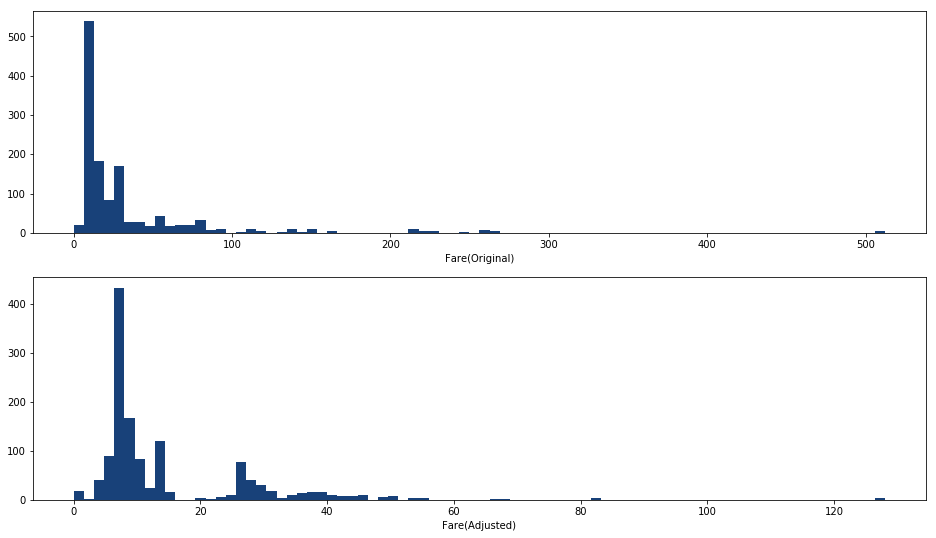

In [262]:
# Fare Adjustment, Fare/# of person
fare_origin = full["Fare"].copy()  # pandasのコピーはデフォでdeep
# print('-'*33)
# print(full.groupby('Ticket')  # group byは値ごとにグループ分け
# グループ分けの結果は出力できないんだってさ
# print('-'*33)
# print(full.groupby('Ticket').Fare.head(10))
# print('-'*33)
# print(full.groupby('Ticket').Fare.count())  
# グループごとに"Fare"の値の種類についてカウント
dict_ticket_size = dict(full.groupby('Ticket').Fare.count())
ticket_size = full["Ticket"].map(dict_ticket_size)
# Ticketの枚数ごとの数、リスト作成
full["Fare"] = full.Fare/ ticket_size

# Plot Fare Adjusted
fit, (ax0, ax1) = plt.subplots(2)
ax0.hist(fare_origin.dropna(), bins=80)
ax0.set_xlabel('Fare(Original)')

ax1.hist(full["Fare"].dropna(), bins=80)
ax1.set_xlabel('Fare(Adjusted)')


In [263]:
# Calculate mean fare cost for each PClass
dict_fare_by_Pclass = dict(full.groupby('Pclass').Fare.mean())
# それぞれのPclassグループに対してFareの平均を対応させる
# fill value according to Pclass
# locはpandas-dataの見たい場所を行と列で指定できる
# mapはリストの各要素に演算を適用してくれるという理解で良さそう
# .mapにしたら.の前が引数になるんだろうなあ
# FareがNullのデータに関して、Pclassを取り出す。
missing_fare = full.loc[full.Fare.isnull(), 'Pclass'].map(dict_fare_by_Pclass)
# fill value according to Pclass
full.loc[full.Fare.isnull(), 'Fare'] = missing_fare

In [264]:
# Descriptive Statistics
print(full.describe())
# :.2fで小数点以下の桁数指定
print("survived: {:.2f}%".format(full.Survived.mean()*100))

               Age         Fare        Parch  PassengerId       Pclass  \
count  1046.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     29.881138    14.751952     0.385027   655.000000     2.294882   
std      14.413493    13.552011     0.865560   378.020061     0.837836   
min       0.170000     0.000000     0.000000     1.000000     1.000000   
25%      21.000000     7.550000     0.000000   328.000000     2.000000   
50%      28.000000     8.050000     0.000000   655.000000     3.000000   
75%      39.000000    15.000000     0.000000   982.000000     3.000000   
max      80.000000   128.082300     9.000000  1309.000000     3.000000   

             SibSp    Survived  
count  1309.000000  891.000000  
mean      0.498854    0.383838  
std       1.041658    0.486592  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       1.000000    1.000000  
max       8.000000    1.000000  
survived: 38.38%


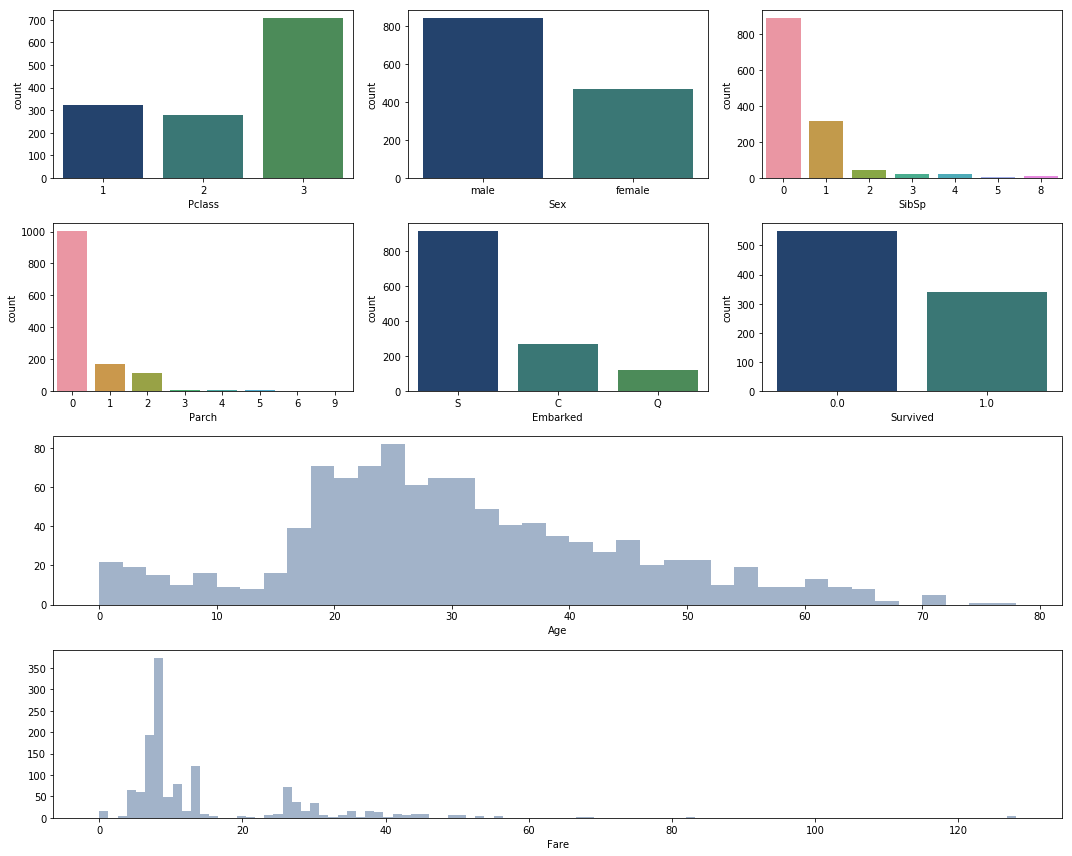

In [265]:
# EDA - Distributions
var_to_plot = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Survived']

# Plot Categorical Var
fig, axs = plt.subplots(4, 3, figsize=(15, 12))
for i, key in enumerate(var_to_plot):
    sns.countplot(key, data=full, ax=axs[i//3, i%3])

# Plot Age
plt.subplot2grid((4,3), (2,0), rowspan=1, colspan=3)
sns.distplot(full.Age.dropna(), bins=range(0, 80, 2), kde=False)
# binは要するに、イテレータで与えてるから始点と終点と刻みが指定できるんだろうなあ
plt.xlabel('Age')

# Plot Fare
# subplot2gridの第一引数：画面を何行何列に分割するのか
# rowspan=1、colspan=3などとすると、領域にまたがってかけるんだろうね。
# 分割した領域のうち、どこにグラフを書くのか
plt.subplot2grid((4,3), (3,0), rowspan=1, colspan=3)
sns.distplot(full.Fare.dropna(), bins=100, kde=False)
plt.xlabel('Fare')
plt.tight_layout()

EDA Relationships between features and survival

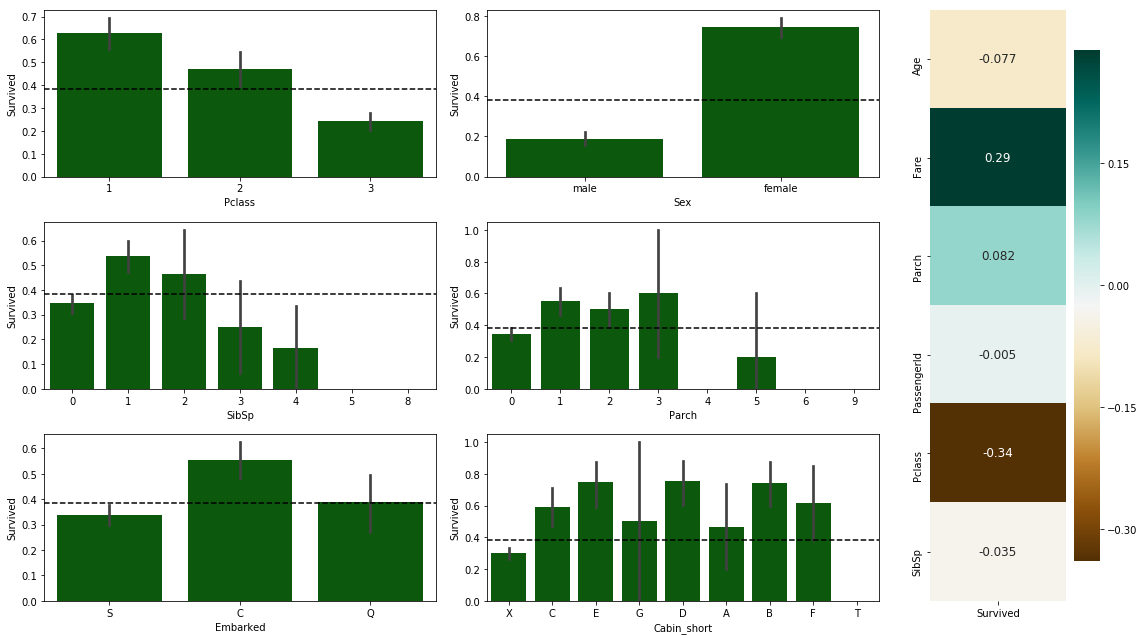

In [266]:
# Plot all categorical features with Survival rate
var_to_plot = ['Pclass', 'Sex', 'SibSp', 'Parch',
               'Embarked', 'Cabin_short']

f, axs = plt.subplots(3,5, sharey=True)
coord = [(0,0), (0,2),(1,0),(1,2),(2,0),(2,2)]
for i, key in enumerate(var_to_plot):
    plt.subplot2grid((3,5),(coord[i]),rowspan=1,colspan=2)
    sns.barplot(data=full,x=key,y='Survived',color='darkgreen')
    plt.axhline(y=0.3838, color='k',linestyle='--')

# Plot Correlation
corr = pd.DataFrame(full.corr()['Survived'][:-1])
plt.subplot2grid((3,5),(0,4),rowspan=3,colspan=1)
sns.heatmap(corr, cmap="BrBG",annot=True,annot_kws={'fontsize':12})
plt.tight_layout()
                     

Fiding from above glaph
１：SexはSurviveに大きく関係している(理由は、女子供が優先的にライフボートに乗せられるからだろうなあ)
２：Pclassが小さいほど生存しやすいことがわかった。単純にライフボートに近い場所に部屋があったため。
３：ヒートマップを見ると、AgeとSurvivedに相関はない
４：Cabinはなんかありそうだけどよーわからん
５：EmbarkはCに行ったら生き残りやすくて、Sだとダメなことがわかる

In [267]:
# Create DataFrame Features to record potential predictors for later model training
# SexとPclassとFareが良さそうなので、そいつらを使う
features = pd.DataFrame()
features['Pclass'] = full['Pclass']
features['Fare'] = full['Fare']
features['Sex'] = full['Sex']

Ticket_short,SCA,SCOW,AS,SCAHB,SP,CASOTON,F,FC,SC,SCAH,...,SOC,A4,SCPARIS,WC,SOTONOQ,STONO2,A5,CA,PC,XXX
mean,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,...,0.166667,0.0,0.428571,0.1,0.133333,0.444444,0.095238,0.341463,0.65,0.384266
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,6.000000,7.0,7.000000,10.0,15.000000,18.000000,21.000000,41.000000,60.00,661.000000


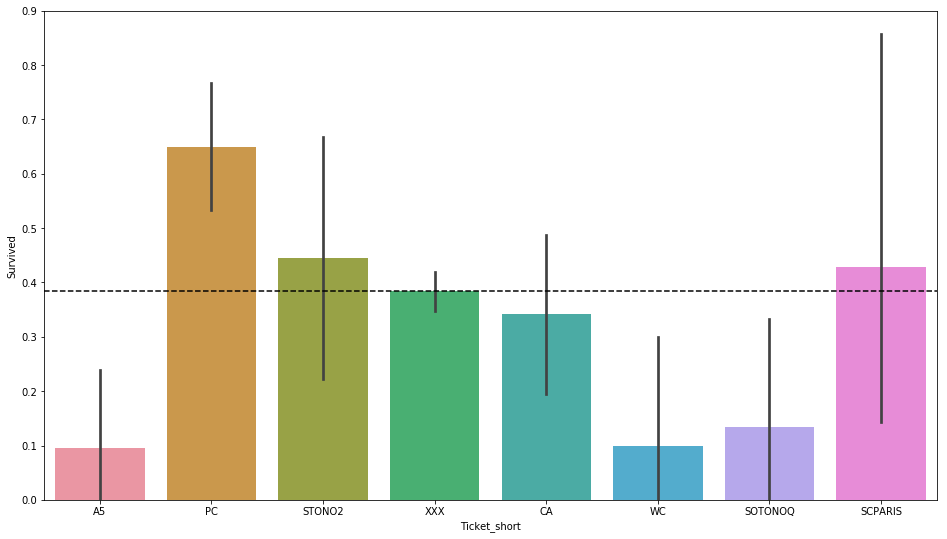

In [268]:
# Ticketの種類がパースした後でも多すぎるので、傾向を見る。
# 10個以上あるものについてのみ
d = dict(full['Ticket_short'].value_counts())
ticket_count = full['Ticket_short'].map(d)
display(full.groupby('Ticket_short')
        .Survived.aggregate(['mean', 'count'])
        .dropna().sort_values('count').transpose())
sns.barplot(data=full[ticket_count > 10],
            x = 'Ticket_short', y ='Survived')
plt.axhline(y=0.3838, color='k', linestyle='--')
         

In [269]:
# 一番生き残るものと、一番生き残らないものを取り出す
# その二つが最も予測性能がいい
features['A5'] = (full['Ticket_short'] == 'A5').astype(int)
# ()内部の演算の結果をTorFで配列にして、intにcastしてboolからintにしてる
features['PC'] = (full['Ticket_short'] == 'PC').astype(int)
# print(features['A5'], full['Ticket_short'])
# print(features['PC'], full['Ticket_short'])

Further exploring the relationship between Pclass, Sex, Age and Survival

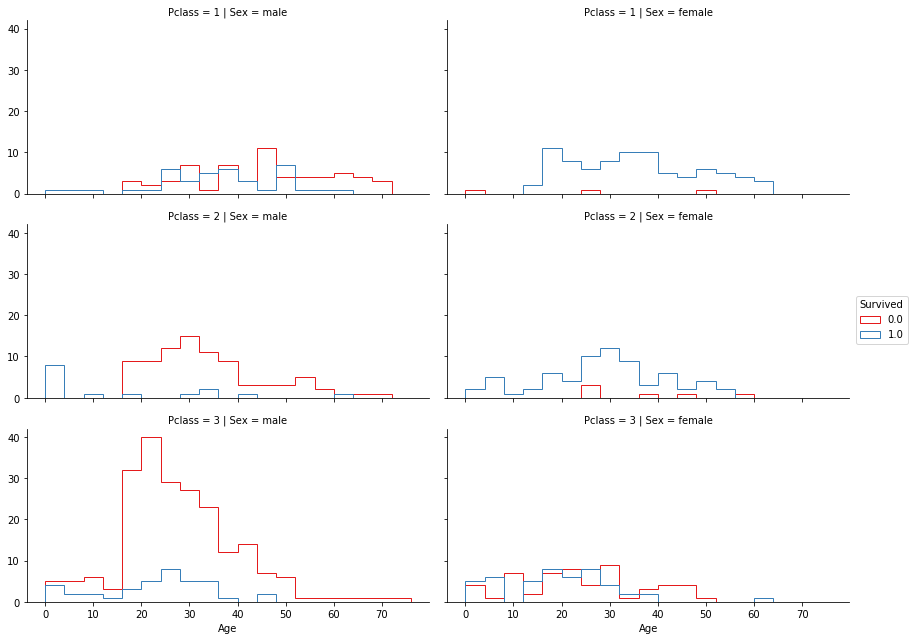

In [270]:
# Facet：一気にグラフ化できる
# なんかよーわからんがrowで縦方向に場合分け、colで横方向に場合分け
# hueで色分けって感じぽい
# aspectでアス比を操作してるっぽい
# facetオブジェクトの初期化
facet = sns.FacetGrid(full, row='Pclass', col='Sex', hue='Survived', aspect=2,
                     palette = 'Set1')
# facetオブジェくとに書き込み
facet.map(plt.hist, 'Age', histtype='step', bins=np.arange(0,80,4))
facet.add_legend()


# 女の方が生き残ってる
# 12歳以下の男生き残ってる
# 3番目のクラスよりも1、２番目のクラスのが生き残ってる


Text(0.5,1,'Across All Classes')

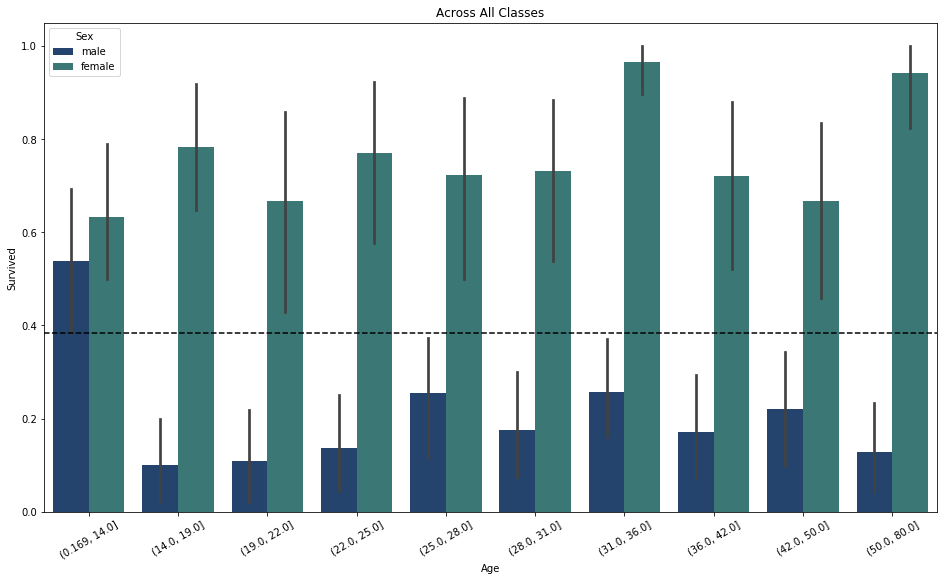

In [271]:
Age_quartile = pd.qcut(full.Age, 10)  # deciles(データ10分割)
sns.barplot(data=full, x=Age_quartile, y='Survived',hue='Sex')
plt.axhline(y=0.3838, color='k', linestyle='--')
plt.xticks(rotation = 30)
plt.title('Across All Classes')

# 女の場合、年齢は生き残りにあんま影響ない
# 男の場合は影響あり。

In [272]:
# parse title from names
# \w:[A-Za-z0-9_]と同じ意味
# \.はただの.
# \s*\w*によって、スペースがある場合の例外処理できる。
def parse_title(str):
    m = re.search(', (\w+\s*\w*)\.', str)
    # print("str", str)
    # print("m.group(0)", m.group(0))
    # print("m.group(1)", m.group(1))
    return m.group(1)

title = full.Name.map(parse_title)
title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

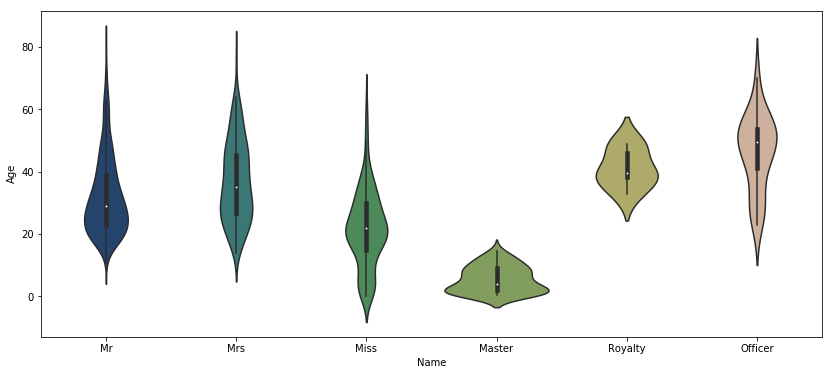

In [273]:
dict_Title = {"Capt": "Officer",
             "Col": "Officer",
              "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

# 外れ値をdictに従って、変換
title = title.map(dict_Title)

# Plot the distribution of Age by Title
plt.figure(figsize = (14, 6))
sns.violinplot(x=title, y=full['Age'])

# Masterが子供


In [274]:
# Calculate mean age of each title group
df_title = pd.DataFrame(title).join(full[['Age', 'Survived']])
dict_age = df_title.groupby('Name').Age.mean()
print(df_title)

# Fill in Age according to passenger's title
idx = full.Age.isnull()
full.loc[idx, 'Age'] = df_title.loc[idx, 'Name'].map(dict_age)
print(full)

                Name   Age  Survived
PassengerId                         
1                 Mr  22.0       0.0
2                Mrs  38.0       1.0
3               Miss  26.0       1.0
4                Mrs  35.0       1.0
5                 Mr  35.0       0.0
6                 Mr   NaN       0.0
7                 Mr  54.0       0.0
8             Master   2.0       0.0
9                Mrs  27.0       1.0
10               Mrs  14.0       1.0
11              Miss   4.0       1.0
12              Miss  58.0       1.0
13                Mr  20.0       0.0
14                Mr  39.0       0.0
15              Miss  14.0       0.0
16               Mrs  55.0       1.0
17            Master   2.0       0.0
18                Mr   NaN       1.0
19               Mrs  31.0       0.0
20               Mrs   NaN       1.0
21                Mr  35.0       0.0
22                Mr  34.0       1.0
23              Miss  15.0       1.0
24                Mr  28.0       1.0
25              Miss   8.0       0.0
2

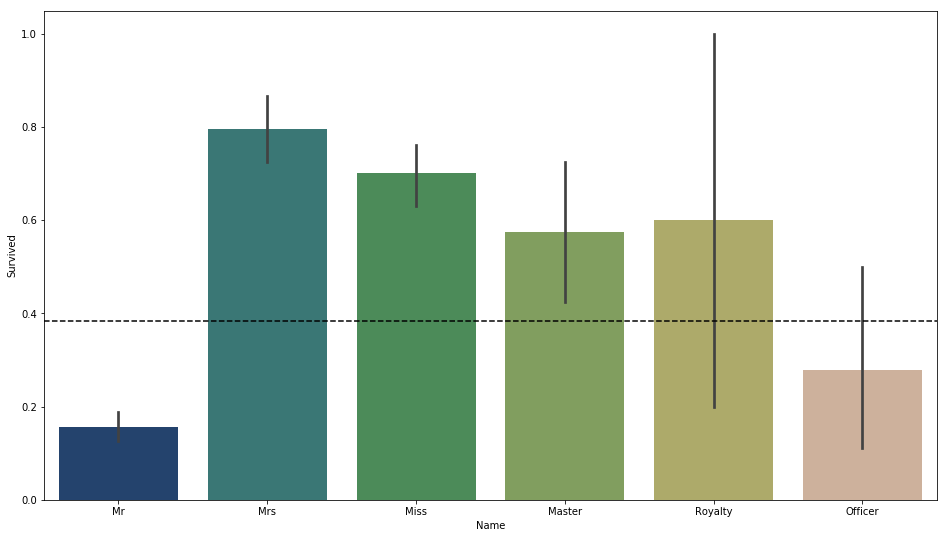

In [275]:
# Plot title with Survived
sns.barplot(data=df_title, x='Name', y='Survived')
plt.axhline(y=0.3838, color='k', linestyle='--')

In [276]:
# Record useful features in featrures dataframe
features['Title'] = df_title['Name']
features['Child'] = (full.Age <= 14).astype(int)
print(features)

             Pclass       Fare     Sex  A5  PC    Title  Child
PassengerId                                                   
1                 3   7.250000    male   1   0       Mr      0
2                 1  35.641650  female   0   1      Mrs      0
3                 3   7.925000  female   0   0     Miss      0
4                 1  26.550000  female   0   0      Mrs      0
5                 3   8.050000    male   0   0       Mr      0
6                 3   8.458300    male   0   0       Mr      0
7                 1  25.931250    male   0   0       Mr      0
8                 3   4.215000    male   0   0   Master      1
9                 3   3.711100  female   0   0      Mrs      0
10                2  15.035400  female   0   0      Mrs      1
11                3   5.566667  female   0   0     Miss      1
12                1  26.550000  female   0   0     Miss      0
13                3   8.050000    male   1   0       Mr      0
14                3   4.467857    male   0   0       Mr

In [277]:
# func to parse surname of the passengers
def parse_surname(name):
    return name.split(',')[0]
# Calculate family size
family = pd.DataFrame(full[['Parch', 'SibSp', 'Ticket']])
family['Family_size'] = 1 + family.Parch + family.SibSp
# family['Family_size']は、それぞれの乗客に関して、自分の家族の構成人数を出してる

# Parse Surname from Name
family['Surname'] = full.Name.map(parse_surname)
# Surname Code and Surname Size
# Surnameごとにグルーピング。それぞれにグループで、family_sizeの数
dict_scount = dict(family.groupby('Surname').Family_size.count())
# .countはデータ全体の個数を数える
# scodeはsurnameそれぞれを番号に変えてる
dict_scode = dict(zip(dict_scount.keys(), range(len(dict_scount))))
print(len(dict_scode))
family['Surname_code'] = family['Surname'].map(dict_scode)
family['Surname_count'] = family['Surname'].map(dict_scount)

print(len(family['Surname'].unique()))
# Example with common surname
# display(full[family.Surname == 'Smith'])
# print(family)
# print(dict_scode)
# print(family.groupby('Surname').Family_size.count())
# print(family[family['Surname'] == 'Abbott'])

875
875


In [278]:
print(family[family['Surname'] == 'Allen'].index)
print(family[family['Surname'] == 'Allen'])

Int64Index([5, 731], dtype='int64', name='PassengerId')
             Parch  SibSp  Ticket  Family_size Surname  Surname_code  \
PassengerId                                                            
5                0      0  373450            1   Allen            15   
731              0      0   24160            1   Allen            15   

             Surname_count  
PassengerId                 
5                        2  
731                      2  


In [279]:
def tick2fam_gen(df):
    '''
    Function to judge if passengers are likely to be in the same family.
    Input: DataFrame with Passenger surname and ticket
    Return: Code generated to specify different families 
    '''
    # initialize ticket dict
    dict_tick2fam = {'000000': 0}
    fam_counter = 0
    
    for i in df.index:
        # print("i", i)
        keys = list(dict_tick2fam.keys())
        chk_key = df.loc[i, 'Ticket']  # passenger_id=iに関して、Ticketnumを調べる
        for key in keys:
            # print("chk_key", chk_key)
            # print("key", key)
            # print("keys[-1]", keys[-1])
            if len(chk_key) == len(key):  # if their tickets have high similarity
                if (chk_key[-4:].isdigit())  & (key[-4:].isdigit()):
                    # print("hoge0")
                    # isdigitは文字列が数字か判定する
                    # 後ろつの数字が同じか、
                    # print("raw", chk_key, key)
                    # print(":-2", chk_key[:-2], key[:-2])  # 先頭から後ろから三番目まで
                    # print("-2:", chk_key[-2:], key[-2:])　#  後ろから2 番目から最後尾
                    if (chk_key[:-2] == key[:-2]) & (np.abs(int(chk_key[-2:])
                         -int(key[-2:])) <= 10):
                        # print("hoge")
                        dict_tick2fam[chk_key] = dict_tick2fam[key]
                        break
            if key == keys[-1]:  # 辞書に登録されてない時
                # print("hoge2")
                fam_counter += 1
                dict_tick2fam[chk_key] = str(fam_counter)
    # print(dict_tick2fam)
    return dict_tick2fam
                        
            

In [280]:
# Single out Surname with size > true family size
# family['Family_size'] < family['Surname_count']は、familyという全ての人のデータが
# のったDataFrameの中で、Family_Sizeつまり、家族の構成人数が、Surname_count
# つまり、Surnameが同じ人の人数より多い。つまり、同じSurnameの家族が複数ある場合を
# 抽出している。
# family['Family_size']は、
surname2chk = family[family['Family_size'] < family['Surname_count']].Surname.unique()

# Regrouping Families according to Family Size and Ticket.
family['Surname_adj'] = family['Surname']
for s in surname2chk:
    family_regroup = family[family['Surname'] == s]
    # Ticketの辞書。各チケット(似てるものは同一とする)に対して、どれだけの人数がいるか
    fam_code_dict = tick2fam_gen(family_regroup)
    for idx in family_regroup.index:
        curr_ticket = full.loc[idx].Ticket  # チケット番号取得
        fam_code = fam_code_dict[curr_ticket]  # チケットを番号に変換
        
        if family_regroup.loc[idx, 'Family_size'] == 1:
            # for passengers traveling alone
            if family_regroup.Ticket.value_counts()[curr_ticket] > 1:
                # Surnameが同一の集団で、TIcketの値に同じ値が二つ以上あるもの
                # ticket番号が同じなのは家族。
                family.loc[idx, 'Surname_adj'] = s + '-hidfam' + fam_code
            else:
                # Surnameが同一の集団で、TIcketの値に同じ値が1つのもの
                family.loc[idx, 'Surname_adj'] = s + '-single' + fam_code
        else:
            family.loc[idx, 'Surname_adj'] = s + '-fam' + fam_code
print(len(family['Surname_adj'].unique()))           
display(family[family.Surname == 'Smith'])

984


,Parch,SibSp,Ticket,Family_size,Surname,Surname_code,Surname_count,Surname_adj
PassengerId,,,,,,,,
175,0,0,17764,1,Smith,747,6,Smith-single1
261,0,0,384461,1,Smith,747,6,Smith-single2
285,0,0,113056,1,Smith,747,6,Smith-single3
347,0,0,31418,1,Smith,747,6,Smith-single4
942,0,1,13695,2,Smith,747,6,Smith-fam5
1287,0,1,13695,2,Smith,747,6,Smith-fam5


In [281]:
# Assign codes to families
dict_fcount = dict(family.groupby('Surname_adj').Family_size.count())  
# 同じfamiyに属する人の数のdict
dict_fcode = dict(zip(dict_fcount.keys(), range(len(dict_fcount))))
# zipは二つのリストをまとめたイテレータにする.リストではないんだなあ
# print(_ for _ in zip(dict_fcount.keys(), range(len(dict_fcount))))
# print(dict_fcount)
family['Family_code'] = family['Surname_adj'].map(dict_fcode)  # familyごとに番号ふる
family["Family_count"] = family['Surname_adj'].map(dict_fcount)  # 構成人数
print("# of family before regrouping {}".format(len(family.Surname_code.unique())))
print("# of family after regrouping {}".format(len(family.Family_code.unique())))



# of family before regrouping 875
# of family after regrouping 984


In [282]:
# 同じチケットで家族じゃなくて友達の人を見つける
# pandasでindexを指定してデータを取り出すときは、引数は1つしか無理→複数だとリスト
group = pd.DataFrame(family[['Surname_code', 'Surname_count',
                            'Family_code', 'Family_count']])
dict_tcount = dict(full.groupby('Ticket').PassengerId.count()) # 同じTicketに対し、何個のPassengeridが対応するか
dict_tcode = dict(zip(dict_tcount.keys(), range(len(dict_tcount))))
group['Ticket_code'] = full.Ticket.map(dict_tcode)
group['Ticket_count'] = full.Ticket.map(dict_tcount)

print('# of Tickets Identified: {}'.format(len(group.Ticket_code.unique())))
display(full[(full.Ticket == 'A/4 48871') | (full.Ticket == 'A/4 48873')])


# of Tickets Identified: 929


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_short,Cabin_short
PassengerId,,,,,,,,,,,,,,
566,24.0,NaN,S,8.05,"Davies, Mr. Alfred J",0,566,3,male,2,0.0,A/4 48871,A4,X
812,39.0,NaN,S,8.05,"Lester, Mr. James",0,812,3,male,0,0.0,A/4 48871,A4,X
901,21.0,NaN,S,8.05,"Davies, Mr. John Samuel",0,901,3,male,2,NaN,A/4 48871,A4,X
1079,17.0,NaN,S,8.05,"Davies, Mr. Joseph",0,1079,3,male,2,NaN,A/4 48873,A4,X


In [283]:
print(full.iloc[:3].index)  # ilocは3行目まで指定できる
# indexは行番号

Int64Index([1, 2, 3], dtype='int64', name='PassengerId')


In [299]:
def ChainCombineGroup(df, colA, colB):
    '''
    This function takes in 2 columns of labels and chain all items which share
    the same labels within each of the 2 columns
    input:
    df - DataFrame
    colA - Key for Col
    colB - key for Col
    output:
    array of numeric grouping labels
    '''
    # make copy of DFs for iterations
    data = df.copy()
    # print(df)
    search_df = data.copy()
    
    group_count = 0
    while not search_df.empty:
        # pd.DataFrame.empty return bool T(if DataFrame is empty) or F
        # Initialize pool and Select Reference item
        pool = search_df.iloc[:1]
        # print("pool", pool)
        idx = pool.index
        
        # Remove 1st item for searching df
        search_df.drop(index=idx, inplace=True)
        
        # Initialize Search
        flag_init = 1
        update = pd.DataFrame()
        
        # While loop exhausively search for commonalities, pool is updated until 
        # no more common features are found
        while (flag_init or not update.empty):
            flag_init = 0
            
            # target labels to look for
            # print("colA", colA)
            # print("pool[colA]", pool[colA]) 
            pool_A_uniq = np.unique(pool[colA])  # 見たいpassengerの特徴量colA
            # np.uniqueはarray変数の要素の重複をなくしたものを返す
            # print("pool_A_uniq", pool_A_uniq)
            pool_B_uniq = np.unique(pool[colB])
            # print("colB", colB)
            # print("pool[colB]", pool[colB])
            # print("pool_B_uniq", pool_B_uniq)
            for col in [colA, colB]:
                idx = []
                # print("pool[col]", pool[col])
                # print("np.unique(pool[col])", np.unique(pool[col]))
                # get all indexs of items with the same label
                for num in np.unique(pool[col]):
                    # print("loop col:{} num:{}".format(col, num))
                    idx.extend(search_df[search_df[col] == num].index)
                    # 元々のデータのcolがnumに一致する成分のindexを追加
                    # 今回は1回目のcolはFamily_code
                    # update pool
                # 同じものをなんかもマージしてた　
                update = search_df.loc[idx]
                # print("update", update)
                pool = pd.concat([pool, update], axis = 0)  
                # 上で一致したものをpoolに加える
                # print("pool1111", pool)
                # remove item from searching df
                search_df = search_df.drop(index=idx) # 追加したものは削除
                # print("-"*30)
                # assign group num
                # print("data.loc[pool.index, 'Group_code']", data.loc[pool.index, 'Group_code'])
            data.loc[pool.index, 'Group_code'] = group_count
        group_count += 1
    return np.array(data['Group_code'].astype(int))

In [300]:
# Assign Final group no.
group['Group_code'] = group['Surname_code']
group['Group_code'] = ChainCombineGroup(group, 'Family_code', 'Ticket_code')
# print(group)

# Calculate group sizes
dict_gcount = dict(group.groupby('Group_code').Family_code.count())
# print("len(dict_gcount)", len(dict_gcount))
group['Group_count'] = group.Group_code.map(dict_gcount)

# print result
print("Family: {}".format(len(family.Family_code.unique())))
print("Group: {}".format(len(group.Ticket_code.unique())))
print("Combined: {}".format(len(group.Group_code.unique())))
print("An example of grouping the both friends and family under a same group")
display(pd.concat([full['Ticket'], family[['Surname', 'Family_code']], 
                   group[['Ticket_code', 'Group_code']]],
        axis=1)[group['Group_code'] == 458])


Family: 984
Group: 929
Combined: 888
An example of grouping the both friends and family under a same group


,Ticket,Surname,Family_code,Ticket_code,Group_code
PassengerId,,,,,
566,A/4 48871,Davies,223,714,458
812,A/4 48871,Lester,512,714,458
901,A/4 48871,Davies,223,714,458
1079,A/4 48873,Davies,223,715,458


In [ ]:
# 20181028